# Facial Keypoints Detection with Post Training Quantization

# Preliminaries

In [ ]:
!pip install wandb

In [5]:
import os
import time 
import pathlib

import pandas as pd
import numpy as np

# Progress Bar
from tqdm.notebook import tqdm

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
# import tensorflow_model_optimization as tfmot       

# wandb
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Config

In [6]:
class config:
  DIRECTORY_PATH = "./Facial Keypoints Detection"
  TRAIN_FILE_PATH = DIRECTORY_PATH + "/input/training.csv"
  TEST_FILE_PATH = DIRECTORY_PATH + "/input/test.csv"
  ID_LOOKUP_TABLE_PATH =  DIRECTORY_PATH + "/input/IdLookupTable.csv"
  SAMPLE_FILE_PATH = DIRECTORY_PATH + "/input/SampleSubmission.csv"
  SUBMISSION_FILE_PATH = DIRECTORY_PATH + "/outputs/submission.csv"

  BASELINE_CHECKPOINT_PATH = DIRECTORY_PATH + "/models/resnet50_baseline/checkpoint.ckpt"
  POST_TRAINING_QUANTIZATION_PATH = DIRECTORY_PATH + "/models/post_training_quantization/resnet50_quant.tflite"

  VALIDATION_DATA_SIZE = 0.2

  BATCH_SIZE = 32
  NUM_EPOCHS = 150
  LEARNING_RATE = 0.03

# Load Data

In [7]:
def load_data():

  """ 
  Function to load the train and test dataset
  """

  X_train = pd.read_csv(config.TRAIN_FILE_PATH)
  X_test_original = pd.read_csv(config.TEST_FILE_PATH)

  return X_train, X_test_original

## Check Missing Values

As there are many missing values, from inspection of data we can conclude that some images have 15 keypoints wherea others have only 4.

We can take two approaches, either to fill/remove missing values and train one model on the entire dataset or use two models, one for data with 4 keypoints and other for data with 15 keypoints and then combine their predictions.

For simplicity, here we are dropping the missing value samples as we want to train only 1 model on the entire dataset and report changes observed via optimization.

In [8]:
def remove_missing_values():

  """
  Function to drop the samples with missing values
  """

  X_train, X_test_original = load_data()

  X_train = X_train.dropna()
  y_train = X_train.drop(['Image'], axis=1)

  return X_train, y_train, X_test_original

## Obtain Images

In [9]:
def get_images():

  """
  Function to get correct images format from the data
  """

  X_train, y_train, X_test_original = remove_missing_values()

  # Train Data
  X_train = X_train.Image
  X_train = X_train.apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((96,96)))

  # Test Data
  X_test_original = X_test_original.Image
  X_test_original = X_test_original.apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((96,96)))

  X_train /= 255.0
  X_test_original /= 255.0

  return X_train, y_train, X_test_original

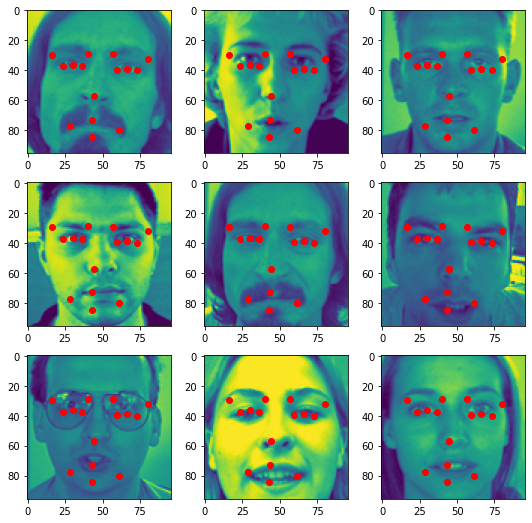

In [10]:
# View Images with their keypoints

X_train, y_train, _ = get_images()

fig = plt.figure(figsize=(9, 9))

for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    for i in range(1, 31, 2):
        plt.plot(y_train.loc[0][i-1], y_train.loc[0][i], 'ro')

plt.show()

## Prepare the Data

In [11]:
def process_data():

  """
  Function to convert, flatten and reshape the arrays
  """

  X_train, y_train, X_test_original = get_images()

  # Convert to arrays
  X_train = X_train.to_numpy()
  X_test_original = X_test_original.to_numpy()

  # Flatten the arrays
  X_train = X_train.flatten()
  X_test_original = X_test_original.flatten()

  X_train = np.concatenate(X_train, axis=0)
  X_train = np.concatenate(X_train, axis=0)

  X_test_original = np.concatenate(X_test_original, axis=0)
  X_test_original = np.concatenate(X_test_original, axis=0)

  # Reshape the arrays to get correct image dimensions
  X_train = X_train.reshape((-1, 96, 96))
  X_test_original = X_test_original.reshape((-1, 96, 96))

  return X_train, y_train, X_test_original

In [12]:
# Obtain Training and Validation Data Splits

def get_data_split():

  """
  Function to obtain train and validation data splits
  """

  X_train, y_train, X_test_original = process_data()

  X_train, X_valid, y_train, y_valid = train_test_split(
      X_train, 
      y_train, 
      test_size=config.VALIDATION_DATA_SIZE, 
      random_state=0
      )

  X_valid, X_test, y_valid, y_test = train_test_split(
      X_valid, 
      y_valid, 
      test_size=config.VALIDATION_DATA_SIZE, 
      random_state=0
      )
  
  return X_train, X_valid, X_test, y_train, y_valid, y_test

A better method to perform data splits will be to use KFold or StratifiedKFold.

In that case we can - 
- Split the data into 5 folds 
- Train 5 different models for each fold and obtain OOF (Out of Fold Predictions)
- Combine all 5 models to generate test predictions using hill climb method.
- To check validation, compare the original target values with the oof predictions.

In this data, a lot of people obtained good results with the usual train test split only, so we can rely upon that.

In [13]:
def get_correct_dimensions():

  """
  Function to convert the data into 3 channels
  """

  X_train, X_valid, X_test, y_train, y_valid, y_test = get_data_split()

  # Reshape all arrays
  X_train = X_train.reshape((-1, 96, 96, 1))
  X_valid = X_valid.reshape((-1, 96, 96, 1))
  X_test = X_test.reshape((-1, 96, 96, 1))

  # Concatenate the data with itself to obtain 3 Channels

  X_train = np.concatenate((X_train, X_train, X_train), axis=-1)
  X_test = np.concatenate((X_test, X_test, X_test), axis=-1)
  X_valid = np.concatenate((X_valid, X_valid, X_valid), axis=-1)

  return X_train, X_test, X_valid, y_train, y_valid, y_test

---

# ResNet50 Baseline Model

For our baseline model we will implement Transfer Learning with a ResNet50 model.

We will use earlystopping here to stop the model training when it starts to overfit.

In [14]:
def get_callbacks(checkpoint_path, callbacks = tf.keras.callbacks):

  """
  Function to declare the callbacks
  """

  early_stopping = callbacks.EarlyStopping(
      min_delta=0.1, # minimium amount of change to count as an improvement
      patience=20, # how many epochs to wait before stopping
      restore_best_weights=True,
  )

  # Create a callback that saves the model's weights
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_path,
      save_weights_only=True,
      )

  # Define the callbacks
  callbacks = [
      keras.callbacks.TensorBoard(log_dir='./logs'),
      early_stopping,
      checkpoint_callback,
      WandbCallback()
  ]

  return callbacks

In [15]:
def get_custom_resnet():

  """
  Function to load pretrained resnet model and freeze certain layers
  """

  inputs = keras.Input(shape=(96, 96, 3))

  # Define the ResNet50 model with pretrained weights (Transfer Learning)
  res_model = ResNet50(
      input_tensor=inputs, 
      weights='imagenet'
      )

  # We will only use certain layers, rest we shall define
  for layer in res_model.layers[:143]:
      layer.trainable = False

  return res_model

### Augmentations and Model

We are using 3 **Data Augmentations** in the model:

1. Random Rotation
2. Random Flip - Both Horizontal and Vertical
3. Random Contrast

In [16]:
# Final Architecture with Data Augmentations
def setup_model():

  """
  Function to define the final model architecture with data augmentations
  """

  res_model = get_custom_resnet()

  model = keras.models.Sequential()
  model.add(keras.layers.RandomRotation(factor = 0.5))
  model.add(keras.layers.RandomFlip())
  model.add(keras.layers.RandomContrast(factor = 0.5))
  model.add(res_model)
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(30, activation='relu'))

  return model

def setup_pretrained_model(checkpoint_path):

  """
  Function to load pretrained model
  """

  model = make_model()
  model.load_weights(checkpoint_path)

  return model

In [17]:
def make_model():

  """
  Function to load model, define optimizer and compile the model
  """

  model = setup_model()
  # Define Optimizer
  optimizer = keras.optimizers.Adam(learning_rate=config.LEARNING_RATE)

  # Compile the model
  model.compile(
  optimizer=optimizer, 
  loss='mean_squared_error', 
  metrics=tf.keras.metrics.RootMeanSquaredError()
  )

  return model

def run_model(checkpoint_path):

  """
  Function to fit the model on the dataset and report the training time
  """

  X_train, X_test, X_valid, y_train, y_valid, y_test = get_correct_dimensions()

  model = make_model()

  callbacks = get_callbacks(checkpoint_path = checkpoint_path)

  # Train model and save history

  start = time.time()

  history = model.fit(
      X_train, 
      y_train, 
      validation_data=(X_valid, y_valid), 
      batch_size=config.BATCH_SIZE, 
      epochs=config.NUM_EPOCHS, 
      callbacks=callbacks
      )

  end = time.time()

  print(f"Total Time taken for Model Training: {end - start} seconds.")

  return history

In [18]:
run = wandb.init(project='Post Training Quantization')

history = run_model(config.BASELINE_CHECKPOINT_PATH)

wandb.finish()

wandb: Currently logged in as: ishandutta (use `wandb login --relogin` to force relogin)


102981632/102967424 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/150
54/54 [==============================] - ETA: 0s - loss: 2472.9463 - root_mean_squared_error: 49.7287

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


54/54 [==============================] - 27s 229ms/step - loss: 2472.9463 - root_mean_squared_error: 49.7287 - val_loss: 2311.3074 - val_root_mean_squared_error: 48.0761
Epoch 2/150
54/54 [==============================] - 9s 173ms/step - loss: 2179.2356 - root_mean_squared_error: 46.6823 - val_loss: 2036.2805 - val_root_mean_squared_error: 45.1252
Epoch 3/150
54/54 [==============================] - 9s 161ms/step - loss: 1920.6732 - root_mean_squared_error: 43.8255 - val_loss: 1794.2871 - val_root_mean_squared_error: 42.3590
Epoch 4/150
54/54 [==============================] - 9s 169ms/step - loss: 1692.0079 - root_mean_squared_error: 41.1340 - val_loss: 1579.8063 - val_root_mean_squared_error: 39.7468
Epoch 5/150
54/54 [==============================] - 9s 169ms/step - loss: 1489.1549 - root_mean_squared_error: 38.5896 - val_loss: 1389.3981 - val_root_mean_squared_error: 37.2746
Epoch 6/150
54/54 [==============================] - 9s 165ms/step - loss: 1309.1903 - root_mean_squared_e

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
root_mean_squared_error,██▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_root_mean_squared_error,██▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,71
best_val_loss,10.17015
epoch,73
loss,10.18504
root_mean_squared_error,3.1914
val_loss,10.17114


In [19]:
def evaluate_model(checkpoint_path):
  """
  Function to calculate loss and root mean squared error on validation dataset
  """

  model = setup_pretrained_model(checkpoint_path)

  _, X_test, _, _, _, y_test = get_correct_dimensions()

  loss, rmse = model.evaluate(X_test, y_test)  # returns loss and metrics
  print("loss: %.2f" % loss)
  print("rmse: %.2f" % rmse)

def get_model_size(path, checkpoint = True):

  """
  Function to obtain the size of a model
  """
  
  if checkpoint:  
    filepath = path + '.data-00000-of-00001'

  else:
    filepath = path
    
  print(f"{os.path.getsize(filepath)/float(1<<20):,.0f} MB")

### Evaluate Model

In [20]:
# Evaluate Model
evaluate_model(config.BASELINE_CHECKPOINT_PATH)

3/3 [==============================] - 3s 76ms/step - loss: 9.3287 - root_mean_squared_error: 3.0543
loss: 9.33
rmse: 3.05


### Model Size

In [21]:
# Model Size
get_model_size(config.BASELINE_CHECKPOINT_PATH)

228 MB


### Baseline Model Conclusion:

Model Description - 
- ResNet50 with Pretrained Weights along with Data Augmentations

Result -
- Root Mean Squared Error = 3.05
- Training Time = 776 seconds
- Model Size = 228 MB

---

# Post Training Quantization 

In [22]:
# Load Baseline Model
model = setup_pretrained_model(config.BASELINE_CHECKPOINT_PATH)

# Build Model
model.build((None, 96,96,3))

### Convert Model to TensorFlow Lite Format

In [23]:
# Convert to TensorFlow Lite Model with optimization

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# Path of TFLite Models
dir_path = config.DIRECTORY_PATH + "/models/post_training_quantization/"

tflite_models_dir = pathlib.Path(dir_path)
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_quant_file = tflite_models_dir/"resnet50_quant.tflite"

# Write File
tflite_model_quant_file.write_bytes(tflite_quant_model)

26228128

### Model Size

In [24]:
# Model Size
get_model_size(config.POST_TRAINING_QUANTIZATION_PATH, checkpoint = False)

25 MB


## Run Model

In [25]:
# Obtain datasets
X_train, X_test, X_valid, y_train, y_valid, y_test = get_correct_dimensions()

In [26]:
# Load Model into Interpreter

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter.allocate_tensors()

### Evaluate on one image

In [27]:
test_image = X_train[0].astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, tf.expand_dims(test_image, axis=0))

interpreter.invoke()
predictions = (interpreter.get_tensor(output_index)).flatten()

mean_squared_error(y_test.iloc[0,:].values, predictions, squared = False)

2.1222900552183614

### Evaluate on validataion dataset

In [28]:
# A helper function to evaluate the TF Lite model using "test" dataset.

def evaluate_quant_model(interpreter):

  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the validation dataset.
  final_predictions = []
  rmse = 0

  for test_image, target in tqdm(zip(X_test, y_test.values), total = len(X_test)):

    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = test_image.astype(np.float32)
    interpreter.set_tensor(input_index, tf.expand_dims(test_image, axis=0))

    # Run inference.
    interpreter.invoke()

    # Post-processing: 
    output = interpreter.tensor(output_index)

    # Obtain Predictions
    predictions = (interpreter.get_tensor(output_index)).flatten()
    final_predictions.append(predictions)

    # Evaluate Model
    rmse += (mean_squared_error(target, predictions, squared = False))/len(X_test)    

  return rmse

In [ ]:
rmse = evaluate_quant_model(interpreter)

print(rmse)

  0%|          | 0/86 [00:00<?, ?it/s]

2.844465952358021

## Post Training Quantization Model Conclusion:

Model Description - 
- ResNet50 with Pretrained Weights along with Data Augmentations
- Post Training Dynamic Range Quantization 

Result -
- Root Mean Squared Error = 2.84 (Considerably better than baseline and mixed precision models)
- Evaluation Time = 199 seconds
- Model Size = 25 MB (10 times smaller than baseline and mixed precision models)

# Final Model and TFLite Inference

Based on the 4 Models we reach to the conclusion that model 3 i.e., Post Training QUantization is giving us the best results with the Root Mean Squared Error of 2.84 and model size of 25 MB.

Thus, our final model will have the following specifications:
- ResNet50 with Pretrained Weights along with Data Augmentations as Base Model
- Post Training Dynamic Range Quantization 
- Inference using TFLite Model

In [ ]:
def tflite_inference(interpreter):
  """
  Function to perform inference of a tflite model
  """

  # Prepare Test Dataset
  _, _, X_test_original = process_data()
  X_test_original = X_test_original.reshape((-1, 96, 96, 1))
  X_test_original = np.concatenate((X_test_original, X_test_original, X_test_original), axis=-1)

  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the validation dataset.
  final_predictions = []

  for test_image in tqdm(X_test_original, total = len(X_test_original)):

    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = test_image.astype(np.float32)
    interpreter.set_tensor(input_index, tf.expand_dims(test_image, axis=0))

    # Run inference.
    interpreter.invoke()

    # Post-processing: 
    output = interpreter.tensor(output_index)

    # Obtain Predictions
    predictions = (interpreter.get_tensor(output_index)).flatten()
    final_predictions.append(predictions)   

  return final_predictions

In [ ]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=config.POST_TRAINING_QUANTIZATION_PATH)
interpreter.allocate_tensors()

predictions = tflite_inference(interpreter)

  0%|          | 0/1783 [00:00<?, ?it/s]

In [ ]:
def generate_submission(predictions):

  """
  Function to create submission file from the model predictions
  """

  # Convert list to array
  predictions = np.array(predictions)

  # Get data
  _, _, _, y_train, _, _ = get_correct_dimensions()
  cols = list(y_train.columns)

  # Load Id LookUp Table
  df = pd.read_csv(config.ID_LOOKUP_TABLE_PATH)

  # Fill the locations
  for i in range(df.shape[0]):
      df.Location[i] = predictions[df.ImageId[i]-1][cols.index(df.FeatureName[i])]

  # Drop Columns which are not required in submission
  df.drop(['ImageId', 'FeatureName'], axis=1, inplace=True)

  # Set ROw Id as index
  df = df.set_index(['RowId'])
  
  # Save submission file
  df.to_csv(config.SUBMISSION_FILE_PATH)

In [ ]:
generate_submission(predictions)

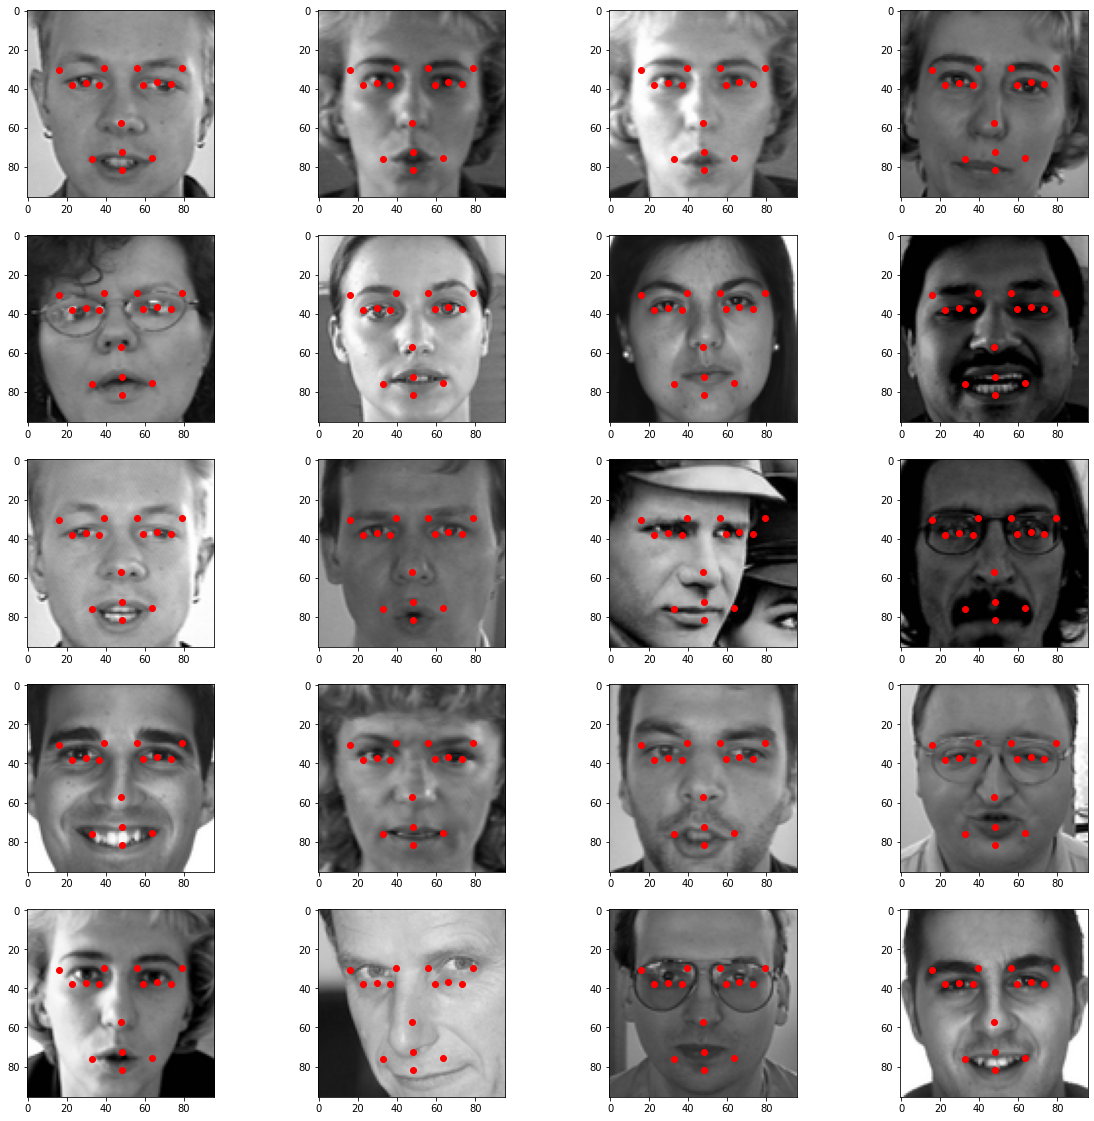

In [ ]:
def plot_test_image(df,prediction, index):
  """
  Function to plot images with their predictions for test set
  """
    image = plt.imshow(df[index])
    l = []
    
    for i in range(1,31,2):
        l.append(plt.plot(prediction[index][i-1], prediction[index][i], 'ro'))
        
    return image, l

fig = plt.figure(figsize=(20, 20))

for i in range(20):
    ax = fig.add_subplot(5, 4, i + 1)
    plot_test_image(X_test,predictions, i)

plt.show()

---